## 2D Heat Conduction

The equation is:

$$\rho c_p \frac{\partial T}{\partial t} = \frac{\partial}{\partial x} \left( k_x \frac{\partial T}{\partial x} \right) + \frac{\partial}{\partial y} \left( k_y \frac{\partial T}{\partial y} \right)$$

Where $\rho$ is the density, $c_p$ is the heat capacity and $k$ is the thermal conductivity.

If the thermal conductivity $k$ is constant we can take it outside of the spatial derivative and the equation becomes:

$$\frac{\partial T}{\partial t} = \alpha \left( \frac{\partial ^2 T}{\partial x^2} + \frac{\partial ^2 T}{\partial y^2} \right)$$

Where $\alpha = \frac{k}{\rho c_p}$ is the thermal diffusivity.  The thermal diffusivity describes the ability of a material to conduct heat vs storing it.

It looks exactly like the diffusion equation.  That's why $\alpha$ is called the thermal diffusivity (duh).

### Problem Statement

Removing heat out of microchips is a big issues in the computer industry.  We're at a point where they can't run much faster because they would start failing to to high temp.

Gotta look at how heat is dissipated from the chip with a simplified model.  Let's consider the chip as a 2D plate that is $1cm x 1cm$ made of Silicon.

$k = 159W/mC$, $c_p = 0.712 * 10^3 J/kgC$, $\rho = 2329kg/m^3$ and diffusivity $\alpha \approx 10^-4 m^2 /rms$.  Silicon melts at $1414^{\circ} C$ but the chips should operate at much smaller temps.  The max temp allowed depends on the model and make.  Usually it is somewhere between $60^{\circ} C$ and $70^{\circ} C$, but better CPUs are recommended to operate at a max of $80^{\circ} C$.

Artificial problem:
The chip is in a position where the top and right edges are in contact with insulating material.  The other two edges are touching components that have a const temp of $T = 100^{\circ} C$ when the machine is operating.  Initially the chip is at room temp $20^{\circ} C$.  How long does it take for the center of the chip to reach $70^{\circ} C$?

## 2D Finite Differences

Two spatial dimensions.  Need to build a 2D grid of discrete points to compute the solution on.

2D Cartesian grid that consists of two families of grid lines parallel to the two spatial directions.  Two lines intersect on one and only one grid node (structured grid).  In the x direction the discretization uses i to N lines and in the y direction j to N lines.  A given node will have two spatial coordinates and we need two indices for the two lines that intersect at that node.

### Explicit Scheme in 2D

Discretized 2D heat equation FT and CS explicit scheme.

$$\frac{T_ij ^{n+1} - T_ij ^n}{\Delta t} = \alpha \left( \frac{T_{i+1j} ^n - 2T_ij ^n + T_{i-1j} ^n}{\Delta x^2} + \frac{T_{ij+1} ^n - 2T_ij ^n + T_{ij-1} ^n}{\Delta y^2} \right)$$

If we rearrange to solve for $T_ij ^{n+1}$ we get:

$$T_ij ^{n+1} = T_ij ^n + \alpha \left( \frac{\Delta t}{\Delta x^2} (T_{i+1j} ^n - 2T_ij ^n + T_{i-1j} ^n) + \frac{\Delta t}{\Delta y^2} (T_{ij+1} ^n - 2T_ij ^n + T_{ij-1} ^n) \right)$$

$T_ij ^{n+1}$ is updated using only know values from the current solution at time $n$.

### Boundary Conditions

Since the problem stated had derivatives at the boundaries we use Neumann.

At every time step we need to enforce:

$$T_{i,end} = q_y * \Delta y + T_{i,end-1}$$

and

$$T_{end,j} = q_x * \Delta x + T_{end-1,j}$$

### Stability

Need to look at the stability constraints.  In 1D explicit discretization of diffusion it was stable as long as $\alpha \frac{\Delta t}{(\Delta x)^2} \leq \frac{1}{2}$.  In 2D the constraint is tighter due to the fact that it needs to be added in both directions:

$$\alpha \frac{\Delta t}{(\Delta x)^2} + \alpha \frac{\Delta t}{(\Delta y)^2} < \frac{1}{2}$$

The mesh will have the same spacing in x and y $\therefore \Delta x = \Delta y = \delta$, then the stability condition is:

$$\alpha \frac{\Delta t}{\delta ^2} < \frac{1}{4}$$

## Code Implementation

### Array storage

Since the physical problem has two dimensions, the temp needs to be stored in a 2D array.

The y coordinate will correspond to the rows of the array and the x coordinate will correspond to the columns.  With the stencil then x will correspond to i and y will coresspond to j. $T_{i,j}$ will be $T[j,i]$ so that it matches the physical orientation.  Because the first element is the row and the second is the column.

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [3]:
def ftcs(T, nt, alpha, dt, dx, dy):
    
    # force j_mid and i_mid will be integers so we can use them as indices
    # for the array T
    
    j_mid = int((numpy.shape(T)[0])/2)
    i_mid = int((numpy.shape(T)[1])/2)
    
    for n in range(nt):
        Tn = T.copy()
        T[1:-1, 1:-1] = Tn[1:-1, 1:-1] + alpha * (dt / dy ** 2 * (Tn[2:, 1:-1] - 2 * Tn[1:-1, 1:-1] + Tn[:-2, 1:-1]) + dt / dx ** 2 * (Tn[1:-1, 2:] - 2 * Tn[1:-1, 1:-1] + Tn[1:-1, :-2]))
        
        #Enforce Neumann BCs
        T[-1, :] = T[-2, :]
        T[:, - 1] = T[: ,-2]
        
        #Check if we reached T = 70 C
        if T[j_mid, i_mid] >= 70:
            print ("Center of the plate reached 70 C at time {0:.2f}s.".format(dt * n))
            break
            
    if T[j_mid, i_mid] < 70:
        print ("Center has not reached 70 C yet, it is only {0:.2f}C.".format(T[j_mid, i_mid]))
        
    return T

In [4]:
# Initial Conditions based on problem set up

L = 1.0e-2
H = 1.0e-2

nx = 21
ny = 21
nt = 500

dx = L / (nx - 1)
dy = H / (ny - 1)

x = numpy.linspace(0, L, nx)
y = numpy.linspace(0, H, ny)

alpha = 1e-4

Ti = numpy.ones((ny, nx)) * 20
Ti[0, :] = 100
Ti[:, 0] = 100

Need to find a time step with: 

$$\frac{\alpha \Delta t}{\Delta x^2} = \frac{\alpha \Delta t}{\Delta y^2} = \frac{1}{4}$$

In [5]:
sigma = 0.25
dt = sigma * min(dx, dy) ** 2 / alpha
T = ftcs(Ti.copy(), nt, alpha, dt, dx, dy)

Center of the plate reached 70 C at time 0.16s.


### Vizualize the results

For two spatial dimensions and temperature to display we need a different type of plot.  Contour! Who would've thought?

Command: **pyplot.contourf** the f means "filled" contours

A meshgrid is needed first for plotting purposes

**numpy.meshgrid** is a function that takes two vectors (x and y for ex) and returns two 2D arrays of x and y coordinates that we then use to create the contour plot.

In [6]:
mx, my = numpy.meshgrid(x, y)

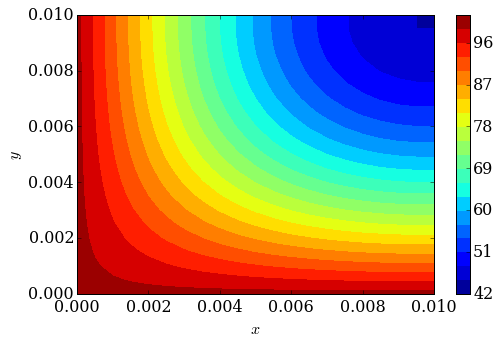

In [7]:
pyplot.figure(figsize = (8, 5))
pyplot.contourf(mx, my, T, 20) # the 20 sets the number of contour levels to display
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar();